# Brain MRI Dataset Preprocessing — 2D Slices with Masks

This notebook extracts random slices from 3D MRI volumes for each modality, normalizes them, and saves both images and segmentation masks in a structured folder layout. This setup is useful for training 2D segmentation models like U-Net.

---



In [68]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

### inspecting data samples

[INFO] Loading NIfTI: ../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001\BraTS20_Training_001_flair.nii
[INFO] Shape: (240, 240, 155)


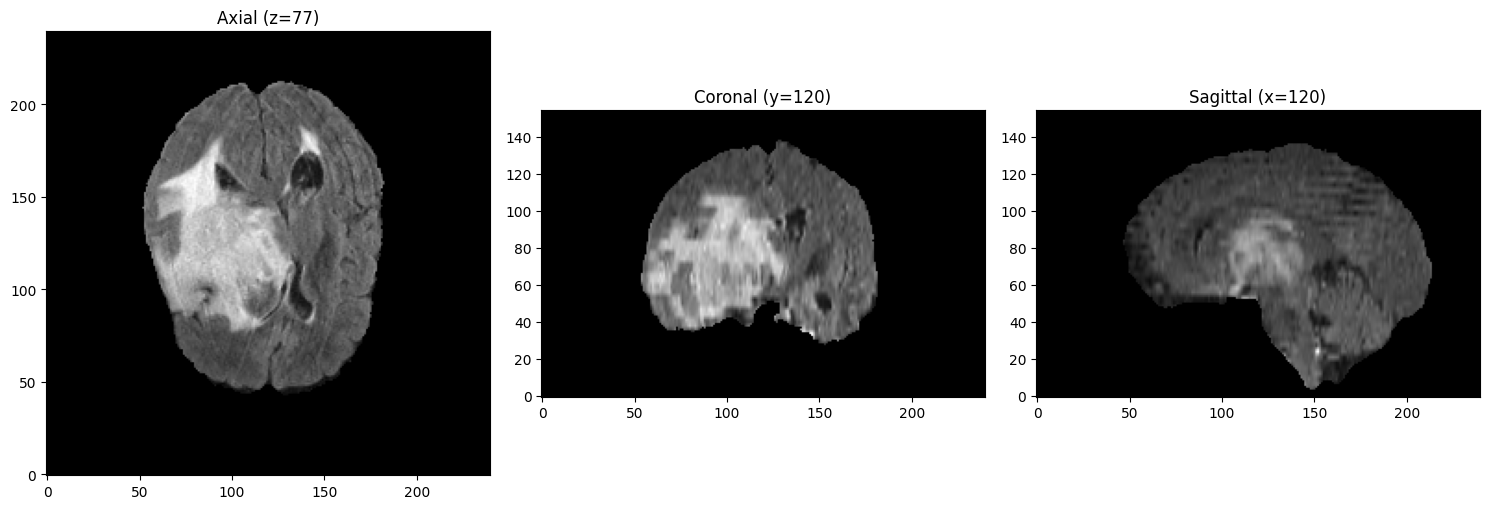

In [69]:
SAMPLE_CASE = "../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001"
MODALITY = "flair"

nii_path = os.path.join(SAMPLE_CASE, f"BraTS20_Training_001_{MODALITY}.nii")
print(f"[INFO] Loading NIfTI: {nii_path}")

img = nib.load(nii_path).get_fdata()
print(f"[INFO] Shape: {img.shape}")  # typically (240, 240, 155)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z direction, like MRI scans are usually shown)
z_mid = img.shape[2] // 2
axes[0].imshow(img[:, :, z_mid].T, cmap="gray", origin="lower") # 20 120
axes[0].set_title(f"Axial (z={z_mid})")

# Coronal (Y direction)
y_mid = img.shape[1] // 2
axes[1].imshow(img[:, y_mid, :].T, cmap="gray", origin="lower") # 50 210
axes[1].set_title(f"Coronal (y={y_mid})")

# Sagittal (X direction)
x_mid = img.shape[0] // 2
axes[2].imshow(img[x_mid, :, :].T, cmap="gray", origin="lower")
axes[2].set_title(f"Sagittal (x={x_mid})")

plt.tight_layout()
plt.show()

### Data format conversion and reorganisation

In [70]:
INPUT_DIR = "../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "../data/sub_dataset"
MODALITIES = ["flair", "t1", "t1ce", "t2"]
NUM_SLICES_PER_PLANE = 3
SEED = 42  # set None for fully random
PLANE_MARGINS = {
    "z": 0.11,  # axial
    "y": 0.20,  # coronal
    "x": 0.21,  # sagittal
}

In [71]:
if SEED is not None:
    random.seed(SEED)
    np.random.seed(SEED)

# Create output folders
os.makedirs(OUTPUT_DIR, exist_ok=True)
for m in MODALITIES:
    os.makedirs(os.path.join(OUTPUT_DIR, m, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, m, "masks"), exist_ok=True)



In [72]:
def normalize_u8(vol):
    """Min-max normalize to 0..255 uint8 (per volume)."""
    vmin, vmax = vol.min(), vol.max()
    if vmax <= vmin + 1e-8:
        return np.zeros_like(vol, dtype=np.uint8)
    vol = (vol - vmin) / (vmax - vmin)
    return (vol * 255).astype(np.uint8)


def pick_random_indices(n, margin, k):
    start = int(n * margin)
    end = int(n * (1 - margin))
    center = start + (end - start) // 2
    std = int(0.25 * (end - start))  # flattening

    indices = []
    while len(indices) < k:
        idx = int(np.random.normal(loc=center, scale=std))
        if np.random.rand() < 0.3:
            idx += np.random.choice([-1, 1]) * np.random.randint(1, max(2, int(0.15 * (end - start))))
        if start <= idx < end:
            indices.append(idx)
    return sorted(indices)


def save_slice_png(arr2d, path):
    """Save 2D array as PNG."""
    plt.imsave(path, arr2d, cmap="gray")


def extract_random_slices_with_mask(vol_path, seg_path, case_id, modality, out_dir):
    """Extract slices for one modality and save corresponding mask in modality folder."""
    vol = nib.load(vol_path).get_fdata()
    vol = normalize_u8(vol)
    mask_vol = nib.load(seg_path).get_fdata()
    mask_vol[mask_vol == 4] = 3  # normalize segmentation labels

    X, Y, Z = vol.shape

    idx_axial = pick_random_indices(Z, PLANE_MARGINS["z"], NUM_SLICES_PER_PLANE)
    idx_coronal = pick_random_indices(Y, PLANE_MARGINS["y"], NUM_SLICES_PER_PLANE)
    idx_sagittal = pick_random_indices(X, PLANE_MARGINS["x"], NUM_SLICES_PER_PLANE)

    for s in idx_axial:
        save_slice_png(vol[:, :, s], os.path.join(out_dir, "images", f"{case_id}_{modality}_axial_{s:03d}.png"))
        save_slice_png(mask_vol[:, :, s], os.path.join(out_dir, "masks", f"{case_id}_{modality}_axial_{s:03d}.png"))

    for s in idx_coronal:
        save_slice_png(vol[:, s, :], os.path.join(out_dir, "images", f"{case_id}_{modality}_coronal_{s:03d}.png"))
        save_slice_png(mask_vol[:, s, :], os.path.join(out_dir, "masks", f"{case_id}_{modality}_coronal_{s:03d}.png"))

    for s in idx_sagittal:
        save_slice_png(vol[s, :, :], os.path.join(out_dir, "images", f"{case_id}_{modality}_sagittal_{s:03d}.png"))
        save_slice_png(mask_vol[s, :, :], os.path.join(out_dir, "masks", f"{case_id}_{modality}_sagittal_{s:03d}.png"))

    return len(idx_axial) + len(idx_coronal) + len(idx_sagittal)


def process_all_cases(dataset_root, output_root=OUTPUT_DIR):
    """Process all cases in dataset_root, saving modality-specific images and masks."""
    case_folders = [os.path.join(dataset_root, d) for d in os.listdir(dataset_root)
                    if os.path.isdir(os.path.join(dataset_root, d))]

    for case_path in tqdm(case_folders, desc="Processing cases"):
        case_id = os.path.basename(case_path)
        seg_file = [f for f in os.listdir(case_path) if "seg" in f][0]
        seg_path = os.path.join(case_path, seg_file)

        for modality in MODALITIES:
            nifti_file = [f for f in os.listdir(case_path) if modality in f][0]
            nifti_path = os.path.join(case_path, nifti_file)
            out_dir = os.path.join(output_root, modality)
            extract_random_slices_with_mask(nifti_path, seg_path, case_id, modality, out_dir)



In [73]:
dataset_root = "../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
process_all_cases(dataset_root)

Processing cases: 100%|██████████| 369/369 [10:11<00:00,  1.66s/it]


### Count check

In [74]:
import os
for modality in MODALITIES:
    img_dir = os.path.join(OUTPUT_DIR, modality, "images")
    mask_dir = os.path.join(OUTPUT_DIR, modality, "masks")

    num_imgs = len([f for f in os.listdir(img_dir) if f.endswith(".png")])
    num_masks = len([f for f in os.listdir(mask_dir) if f.endswith(".png")])

    print(f"{modality}: images = {num_imgs}, masks = {num_masks}")


flair: images = 3292, masks = 3292
t1: images = 3291, masks = 3291
t1ce: images = 3289, masks = 3289
t2: images = 3292, masks = 3292
